# Load the Dataset

In [122]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA
# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [123]:
def create_pivot_table(df):
    """
    Creates a pivot table from player statistics and flattens column names
    """
    # Create pivot table
    pivot_df = df.pivot_table(
        index=["Player", "Versus", "BasedOnMinutes", "scouting_period"],
        columns=["Statistic"],
        values=["Per90", "Percentile"]
    ).reset_index()
    
    # Flatten column names
    pivot_df.columns = [
        '_'.join(str(i) for i in col if str(i) != '')
        if isinstance(col, tuple) else str(col)
        for col in pivot_df.columns
    ]
    
    return pivot_df

In [124]:
# # List of input CSV files
# input_files = [
#     "data/Arsenal_Scouting_Data.xlsx",
#     "data/AstonVilla_Scouting_Data.xlsx",
#     "data/Bournemouth_Scouting_Data.xlsx",
#     "data/Brentford_Scouting_Data.xlsx",
#     "data/Brighton_Scouting_Data.xlsx",
#     "data/Chelsea_Scouting_Data.xlsx",
#     "data/CrystalPalace_Scouting_Data.xlsx",
#     "data/Everton_Scouting_Data.xlsx",
#     "data/Fulham_Scouting_Data.xlsx",
#     "data/IpswichTown_Scouting_Data.xlsx",
#     "data/Leicester_City_Scouting_Data.xlsx",
#     "data/ManchesterUtd_Scouting_Data.xlsx",
#     "data/ManCity_Scouting_Data.xlsx",
#     "data/NewcastleUtd_Scouting_Data.xlsx",
#     "data/NottinghamForest_Scouting_Data.xlsx",
#     "data/Southampton_Scouting_Data.xlsx",
#     "data/Spurs_Scouting_Data.xlsx",
#     "data/WestHam_Scouting_Data.xlsx",
#     "data/WolverhamptonWanderers_Scouting_Data.xlsx",
#     "data/liverpool_trial_1.csv"
# ]

# # List to hold DataFrames
# df_list = []

# # Read each file and append to the list
# for file in input_files:
#     if file.endswith('.xlsx'):
#         df = pd.read_excel(file)
#     elif file.endswith('.csv'):
#         df = pd.read_csv(file)
#     df_list.append(df)
# combined_df = pd.concat(df_list, ignore_index=True)

# # Split into goalkeeper and outfield player data frames
# gk_df = combined_df[combined_df['Versus'] == 'Goalkeepers']
# outfield_df = combined_df[combined_df['Versus'] != 'Goalkeepers']

# gk_df = create_pivot_table(gk_df)
# outfield_df = create_pivot_table(outfield_df)

# gk_df.to_csv("transformed_data/goalkeeper_stats.csv", index=False)
# outfield_df.to_csv("transformed_data/outfield_stats.csv", index=False)

In [125]:
gk_df = pd.read_csv("transformed_data/goalkeeper_stats.csv")
outfield_df = pd.read_csv("transformed_data/outfield_stats.csv")
print(f"Number of goalkeeper records: {len(gk_df)}")
print(f"Number of outfield player records: {len(outfield_df)}")

Number of goalkeeper records: 362
Number of outfield player records: 3958


In [126]:
gk_df.head()

,Player,Versus,BasedOnMinutes,scouting_period,Per90_Average Pass Length,Per90_Avg. Distance of Def. Actions,Per90_Avg. Length of Goal Kicks,Per90_Clean Sheet Percentage,Per90_Clean Sheets,Per90_Corner Kick Goals Against,...,Percentile_Penalty Kicks Attempted,Percentile_Penalty Kicks Missed,Percentile_Penalty Kicks Saved,Percentile_Post-Shot Expected Goals,Percentile_Save Percentage,Percentile_Save% (Penalty Kicks),Percentile_Saves,Percentile_Shots on Target Against,Percentile_Throws Attempted,Percentile_Wins
0,Aaron Ramsdale,Goalkeepers,300,2022-2023 Europa League,38.2,17.5,65.0,33.3,0.33,0.33,...,21.0,49.0,46.0,79.0,28.0,NaN,13.0,16.0,48.0,45.0
1,Aaron Ramsdale,Goalkeepers,540,2023-2024 Premier League,33.3,14.6,41.4,33.3,0.33,0.17,...,6.0,45.0,41.0,98.0,23.0,NaN,5.0,5.0,63.0,98.0
2,Aaron Ramsdale,Goalkeepers,1260,2024-2025 Premier League,33.5,12.2,45.3,14.3,0.14,0.50,...,66.0,50.0,38.0,9.0,41.0,38.0,95.0,98.0,77.0,9.0
3,Aaron Ramsdale,Goalkeepers,1350,"Last 365 Days Men's Big 5 Leagues, UCL, UEL",34.4,11.4,44.8,13.3,0.13,0.47,...,44.0,40.0,27.0,1.0,39.0,27.0,98.0,98.0,81.0,5.0
4,Aaron Ramsdale,Goalkeepers,3060,2021-2022 Premier League,33.2,16.4,55.1,35.3,0.35,0.09,...,73.0,90.0,37.0,71.0,75.0,37.0,33.0,21.0,63.0,90.0


In [127]:
outfield_df.head()

,Player,Versus,BasedOnMinutes,scouting_period,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,...,Percentile_Touches (Def Pen),Percentile_Touches (Live-Ball),Percentile_Touches (Mid 3rd),Percentile_Yellow Cards,Percentile_npxG + xAG,Percentile_npxG/Shot,Percentile_npxG: Non-Penalty xG,Percentile_xA: Expected Assists,Percentile_xAG: Exp. Assisted Goals,Percentile_xG: Expected Goals
0,Aaron Cresswell,Center Backs,3069,2017-2018 Premier League,54.8,63.3,1.38,1.67,0.21,28.7,...,3.0,64.0,63.0,31.0,80.0,8.0,23.0,92.0,96.0,23.0
1,Aaron Cresswell,Fullbacks,416,2023-2024 Europa League,50.0,66.7,1.30,1.30,0.00,15.5,...,37.0,67.0,69.0,46.0,26.0,78.0,36.0,47.0,31.0,35.0
2,Aaron Cresswell,Fullbacks,517,2022-2023 Europa Conference League,22.2,80.0,1.22,0.35,0.35,25.0,...,39.0,77.0,90.0,20.0,49.0,24.0,12.0,65.0,67.0,12.0
3,Aaron Cresswell,Fullbacks,664,"Last 365 Days Men's Big 5 Leagues, UCL, UEL",52.9,83.3,1.08,1.22,0.00,23.6,...,66.0,49.0,41.0,25.0,32.0,72.0,32.0,45.0,45.0,32.0
4,Aaron Cresswell,Fullbacks,696,2021-2022 Europa League,55.6,44.4,0.52,0.65,0.26,20.1,...,34.0,89.0,76.0,58.0,95.0,50.0,26.0,99.0,99.0,25.0


# Split the dataset

Split after we combine with valuation

# Preprocessing

In [128]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 3958
Number of outfield player records after dropping duplicates: 3958


Visualising and dropping rows where with players that didn't play enough for sample to be representative

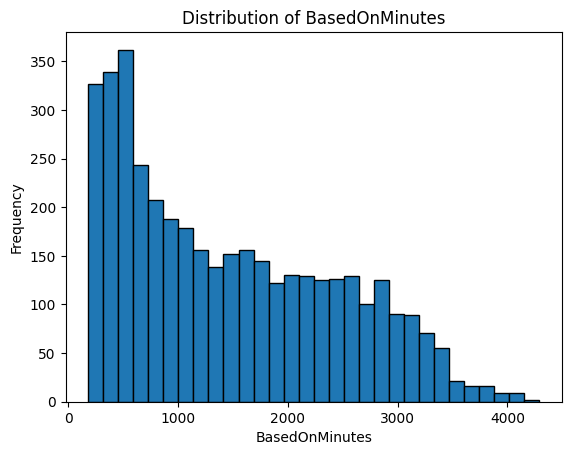

In [129]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [130]:
# Dropping all entries with BasedOnMinutes less than 450 min, playing less than 5 games
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= 450]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 3958
Number of outfield outfield records after filtering: 3323


Combining rows to ensure that one entry is tagged to only one unique player

In [131]:
# continue with preprocessing to ensure there will only be one unique entry per player


Dropping per 90 data

In [132]:
# drop per90

# Initial number of columns
initial_column_count = outfield_df.shape[1]

# Drop columns with "Per90" in their name
columns_to_drop = [col for col in outfield_df.columns if 'Per90' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)

# Final number of columns
final_column_count = outfield_df.shape[1]
columns_dropped = initial_column_count - final_column_count

print(f"Number of columns before dropping 'Per90': {initial_column_count}")
print(f"Number of columns after dropping 'Per90': {final_column_count}")
print(f"Number of columns dropped: {columns_dropped}")

Number of columns before dropping 'Per90': 238
Number of columns after dropping 'Per90': 121
Number of columns dropped: 117


Handling na values

In [133]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [134]:
na_columns_goal_related = ['Percentile_Goals/Shot on Target', 
                           'Percentile_npxG/Shot', 
                           'Percentile_Average Shot Distance', 
                           'Percentile_Goals/Shot', 
                           'Percentile_Shots on Target %']
na_columns_dribble_related = ['Percentile_Successful Take-On %',
                              'Percentile_Tackled During Take-On Percentage']
na_columns_others = ['Percentile_% of Dribblers Tackled',
                     'Percentile_% of Aerials Won',
                     'Percentile_Pass Completion % (Long)']
# Fill missing values with 0 as corresponding player is not involved in those actions, suggesting they are not good at it.
outfield_df[na_columns_goal_related] = outfield_df[na_columns_goal_related].fillna(0)
outfield_df[na_columns_dribble_related] = outfield_df[na_columns_dribble_related].fillna(0)
outfield_df[na_columns_others] = outfield_df[na_columns_others].fillna(0)

In [135]:
# # If Per90 is not dropped
# na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
#                                  'Per90_npxG/Shot', 
#                                  'Per90_Average Shot Distance', 
#                                  'Per90_Goals/Shot', 
#                                  'Per90_Shots on Target %']
# na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
#                                     'Per90_Tackled During Take-On Percentage']
# na_columns_dribble_related_per90 = ['Per90_% of Dribblers Tackled',
#                                     'Per90_% of Aerials Won',
#                                     'Per90_Pass Completion % (Long)']
# outfield_df[na_columns_goal_related_per90] = outfield_df[na_columns_goal_related_per90].fillna(0)
# outfield_df[na_columns_dribble_related_per90] = outfield_df[na_columns_dribble_related_per90].fillna(0)
# outfield_df[na_columns_others] = outfield_df[na_columns_others].fillna(0)

In [136]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Feature Scaling (Z-score, min-max, maxAbs etc.)

Feature Engineering

In [137]:
# Compute the Goals per Expected Goals Ratio
outfield_df["Finishing_Efficiency"] = outfield_df["Percentile_Goals"] / outfield_df["Percentile_Goals - xG"]

# Handle cases where xG is zero (avoid division by zero)
outfield_df["Finishing_Efficiency"] = outfield_df["Finishing_Efficiency"].replace(float('inf'), 0)

# Drop Percentile_Goals - xG
outfield_df = outfield_df.drop(columns=["Percentile_Goals - xG"])

# Compute the Assists per Expected Assists Ratio
outfield_df["Assist_Efficiency"] = outfield_df["Percentile_Assists"] / outfield_df["Percentile_xA: Expected Assists"]
outfield_df["Assist_Efficiency"] = outfield_df["Assist_Efficiency"].replace(float('inf'), 0)
outfield_df = outfield_df.drop(columns=["Percentile_xA: Expected Assists"])

Finding correlation between features and dropping those that are highly correlated

Reducing Dimension

Number of features before PCA: 117
Number of features after PCA: 62


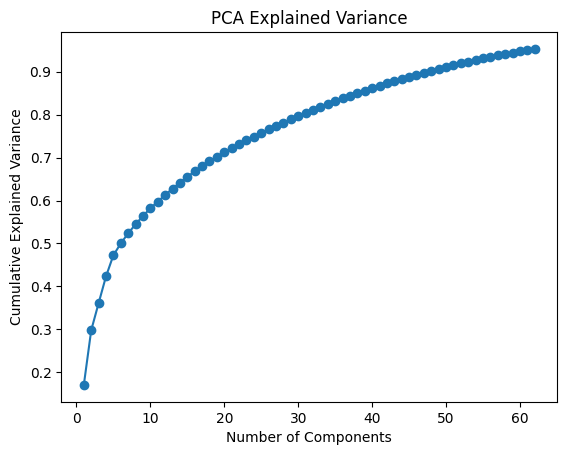

In [139]:
# Specify categorical columns to keep
non_statistical_data = ["Player", "Versus", "BasedOnMinutes", "scouting_period"]  

# Separate categorical and numerical features
kept_features_df = outfield_df[non_statistical_data].reset_index(drop=True)  # Reset index for safe merge
features = outfield_df.drop(columns=non_statistical_data)  # Drop categorical columns for PCA

# Print the number of features before PCA
print("Number of features before PCA:", features.shape[1])

# Standardize numerical features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA output back to DataFrame
pca_df = pd.DataFrame(X_pca, index=outfield_df.index)

# Name PCA columns properly
pca_df.columns = [f'PCA_{i+1}' for i in range(pca_df.shape[1])]

# Concatenate categorical columns with PCA-transformed numerical data
outfield_df_pca = pd.concat([kept_features_df, pca_df.reset_index(drop=True)], axis=1)

# Print the number of features after PCA
print("Number of features after PCA:", pca_df.shape[1])

# Plot PCA explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("PCA Explained Variance")
plt.show()

Encoding Categorical Variables

In [ ]:
print("Columns before encoding:", outfield_df.columns)
outfield_df = pd.get_dummies(outfield_df, columns=['Versus', 'scouting_period'])
print("Columns after encoding:", outfield_df.columns)

Columns before encoding: Index(['Player', 'Versus', 'BasedOnMinutes', 'scouting_period',
       'Percentile_% of Aerials Won', 'Percentile_% of Dribblers Tackled',
       'Percentile_Aerials Lost', 'Percentile_Aerials Won',
       'Percentile_Assists', 'Percentile_Average Shot Distance',
       ...
       'Percentile_Touches (Def Pen)', 'Percentile_Touches (Live-Ball)',
       'Percentile_Touches (Mid 3rd)', 'Percentile_Yellow Cards',
       'Percentile_npxG + xAG', 'Percentile_npxG/Shot',
       'Percentile_npxG: Non-Penalty xG', 'Percentile_xA: Expected Assists',
       'Percentile_xAG: Exp. Assisted Goals', 'Percentile_xG: Expected Goals'],
      dtype='object', length=121)
Columns after encoding: Index(['Player', 'BasedOnMinutes', 'Percentile_% of Aerials Won',
       'Percentile_% of Dribblers Tackled', 'Percentile_Aerials Lost',
       'Percentile_Aerials Won', 'Percentile_Assists',
       'Percentile_Average Shot Distance', 'Percentile_Ball Recoveries',
       'Percentile_Blocks

Others (Removing outliers)

# Clustering

## K Means

Custom Initial Cluster Centers:
 [[ 0.60048107 -0.07009542  0.48776212 ...  1.12376566  0.04725789
  -0.04523344]
 [-0.11170201  0.25474134  0.03356177 ... -0.60907863 -0.22936138
   0.05736245]
 [ 0.29649111 -0.07781705 -0.78460098 ...  0.85832785 -0.09489298
  -0.13773148]
 ...
 [-0.22763824 -0.08191975  0.45007271 ...  0.52423324  0.04638507
  -0.18740139]
 [ 0.36156244  0.50027353  0.19653191 ...  0.70247682 -0.01172724
  -0.16776259]
 [ 0.09938371 -0.14379478  0.3532031  ... -1.11869283 -0.26252325
  -0.1583959 ]]


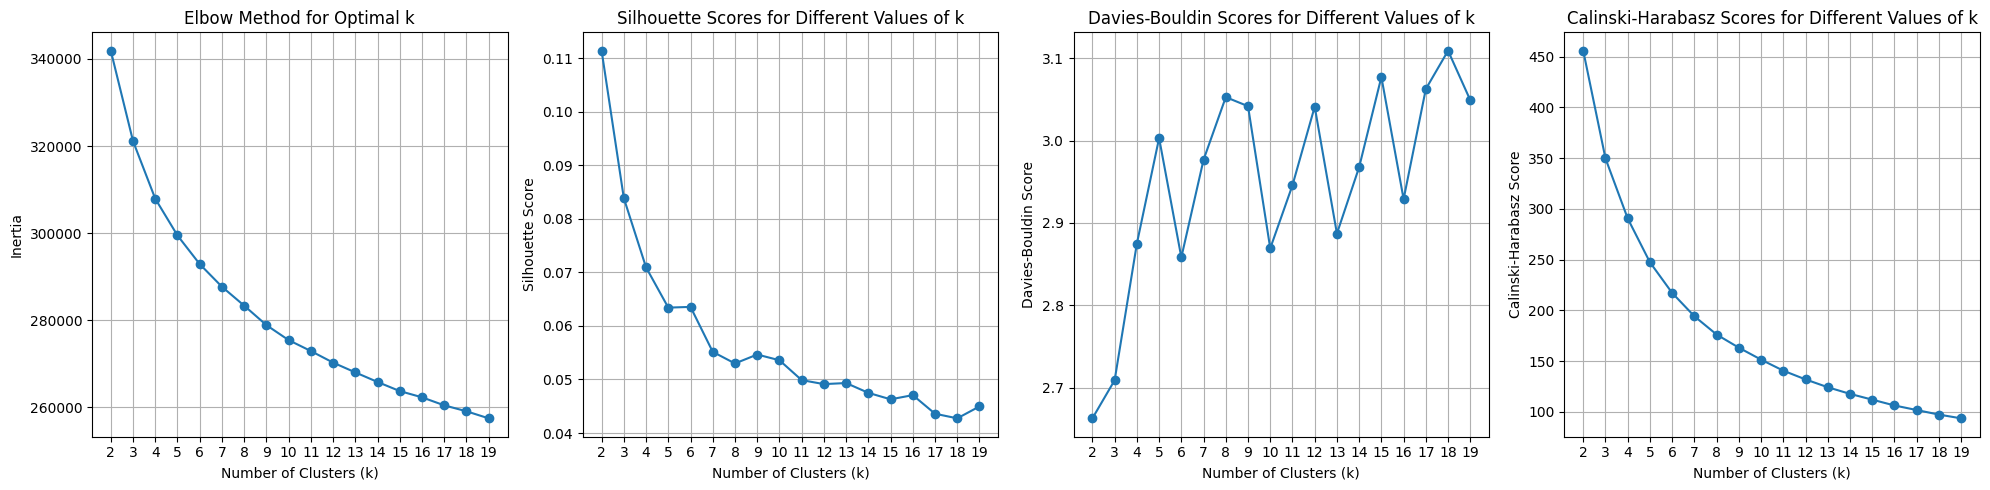

Best k according to Elbow Method: 2
Best k according to Silhouette Score: 2
Best k according to Davies-Bouldin Score: 2
Best k according to Calinski-Harabasz Score: 2


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Select features for clustering (exclude categorical columns)
features = outfield_df.drop(columns=['Player', 'Versus', 'BasedOnMinutes', 'scouting_period'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Ensure selected players exist before computing centroids
selected_players = ["Kevin De Bruyne", "Virgil van Dijk", "Erling Haaland"]
existing_players = outfield_df[outfield_df["Player"].isin(selected_players)].copy()

if len(existing_players) < len(selected_players):
    print(f"Warning: Not all selected players exist in dataset! Found {len(existing_players)}.")

# Drop categorical columns from existing players
numeric_features = existing_players.drop(columns=['Player', 'Versus', 'BasedOnMinutes', 'scouting_period'])

# Standardize existing player stats **before computing centroids**
scaled_existing_players = scaler.transform(numeric_features)

# Compute centroid values for known archetypes
centroids = np.array(scaled_existing_players)

# Fit KMeans using expert-chosen centroids
k_means = KMeans(n_clusters=centroids.shape[0], init=centroids, n_init=1, random_state=42)
k_means.fit(scaled_features)

# Get cluster labels
labels = k_means.labels_
print("Custom Initial Cluster Centers:\n", k_means.cluster_centers_)

# Range of k values to try
k_values = range(2, 20)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop through different values of k
for k in k_values:
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
    k_means.fit(scaled_features)
    labels = k_means.labels_
    
    inertia.append(k_means.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_features, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(scaled_features, labels))

# Plot the evaluation metrics
plt.figure(figsize=(20, 5))

# Plot the inertia values (Elbow Method)
plt.subplot(1, 4, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# Plot the silhouette scores
plt.subplot(1, 4, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

# Plot the Davies-Bouldin scores
plt.subplot(1, 4, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_values)
plt.grid(True)

# Plot the Calinski-Harabasz scores
plt.subplot(1, 4, 4)
plt.plot(k_values, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

# Function to find the elbow point
def find_elbow_point(inertia):
    diff = np.diff(inertia)
    diff_r = diff[1:] / diff[:-1]
    elbow_point = np.argmin(diff_r) + 2  # +2 because diff reduces the length by 1 and we start from k=2
    return elbow_point

# Find the best k for each metric
best_k_elbow = find_elbow_point(inertia)
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_davies_bouldin = k_values[np.argmin(davies_bouldin_scores)]
best_k_calinski_harabasz = k_values[np.argmax(calinski_harabasz_scores)]

print(f"Best k according to Elbow Method: {best_k_elbow}")
print(f"Best k according to Silhouette Score: {best_k_silhouette}")
print(f"Best k according to Davies-Bouldin Score: {best_k_davies_bouldin}")
print(f"Best k according to Calinski-Harabasz Score: {best_k_calinski_harabasz}")

# Classification

## KNN

In [ ]:
# Manually specify certain players and their archetypes
player_archetypes = {
    'Trent Alexander-Arnold' : 'Wing Back'
}

# Add a new column for archetypes and label the specified players
outfield_df['Archetype'] = outfield_df['Player'].map(player_archetypes)

# Separate the labeled and un_labelled data
labeled_data = outfield_df.dropna(subset=['Archetype']).copy()
un_labelled_data = outfield_df[outfield_df['Archetype'].isna()].copy()

# continue...